<a href="https://colab.research.google.com/github/Kazuya-Y/public/blob/main/Kazuya_%E3%83%87%E3%83%BC%E3%82%BF%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
##CEFRのデータを追加する

import pandas as pd
df_monthly_test_results=pd.read_csv('/content/monthly_test_results_20260127_210102.csv')
df_study_time_monthly=pd.read_csv('/content/study_time_monthly_20260127_210031.csv')

df_monthly_test_results['テスト種類']
col_needed=['受講生ID','受講生名','実施日','テスト種類','総合']
df_monthly_test_results=df_monthly_test_results[col_needed]

def versant_score_to_cefr(score):
    if 10 <= score <= 29:
        return 'A1'
    elif 30 <= score <= 42:
        return 'A2'
    elif 43 <= score <= 58:
        return 'B1'
    elif 59 <= score <= 75:
        return 'B2'
    elif 76 <= score <= 84:
        return 'C1'
    elif 85 <= score <= 90:
        return 'C2'
    else:
        return None

def versant_sl_score_to_cefr(score):
    if  score <= 35:
        return 'A1'
    elif 36 <= score <= 46:
        return 'A2'
    elif 47 <= score <= 57:
        return 'B1'
    elif 58 <= score <= 68:
        return 'B2'
    elif 69 <= score <= 78:
        return 'C1'
    elif 79 <= score <= 80:
        return 'C2'
    else:
        return None

def casec_score_to_cefr(score):
    if 0 <= score <= 444:
        return 'A1'
    elif 445 <= score <= 609:
        return 'A2'
    elif 610 <= score <= 729:
        return 'B1'
    elif 730 <= score <= 860:
        return 'B2'
    elif 861 <= score <= 1000:
        return 'C1'
    else:
        return None

def cefr_to_num(cefr):
    if cefr == 'A1':
        return 1
    elif cefr == 'A2':
        return 2
    elif cefr == 'B1':
        return 3
    elif cefr == 'B2':
        return 4
    elif cefr == 'C1':
        return 5
    elif cefr == 'C2':
        return 6
    else:
        return None

mask = df_monthly_test_results['テスト種類'] == 'Versant'
df_monthly_test_results.loc[mask, 'CEFR'] = df_monthly_test_results.loc[mask, '総合'].apply(versant_score_to_cefr)

mask_sl = df_monthly_test_results['テスト種類'] == 'Versant Speaking & Listening'
df_monthly_test_results.loc[mask_sl, 'CEFR'] = df_monthly_test_results.loc[mask_sl, '総合'].apply(versant_sl_score_to_cefr)

mask_casec = df_monthly_test_results['テスト種類'] == 'CASEC'
df_monthly_test_results.loc[mask_casec, 'CEFR'] = df_monthly_test_results.loc[mask_casec, '総合'].apply(casec_score_to_cefr)

df_casec_s=pd.read_csv('/content/CASEC_Speaking_CEFR.csv')
df_temp_casec_s=df_monthly_test_results[df_monthly_test_results['テスト種類']=='CASEC Speaking']
df_temp_non_casec_s=df_monthly_test_results[df_monthly_test_results['テスト種類']!='CASEC Speaking']

df_temp_casec_s = df_temp_casec_s.merge(
    df_casec_s,
    on=["受講生名", "総合"],
    how="left",
    suffixes=("", "_casec")
)

df_temp_casec_s = df_temp_casec_s.drop(columns=["CEFR"])
df_temp_casec_s = df_temp_casec_s.rename(columns={"CEFR_casec": "CEFR"})

df_monthly_test_results = pd.concat([df_temp_non_casec_s, df_temp_casec_s], ignore_index=True)
df_monthly_test_results['CEFR_score']=df_monthly_test_results['CEFR'].apply(cefr_to_num)
df_monthly_test_results=df_monthly_test_results.drop(columns=["受講生名"])

In [111]:
df_monthly_test_results[df_monthly_test_results['受講生ID']==1554]

,受講生ID,実施日,テスト種類,総合,CEFR,CEFR_score
2452,1554,2025-02-11,Versant,618,None,NaN


In [77]:
from google.colab import files
df_test=df_monthly_test_results[df_monthly_test_results['テスト種類']=='CASEC Speaking'].head(30)
df_test.to_csv("data.csv", index=False, encoding="utf-8-sig")
files.download("data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [112]:
##CEFRの変化のデータを追加する

# 受講生IDごとに「最も早い実施日」の CEFR_score を取得
first_scores = (
    df_monthly_test_results.loc[df_monthly_test_results.groupby("受講生ID")["実施日"].idxmin()]
    .set_index("受講生ID")["CEFR_score"]
)

df_monthly_test_results["score_first"] = df_monthly_test_results["受講生ID"].map(first_scores)

# 受講生IDごとに「最も遅い実施日」の CEFR_score を取得
last_scores = (
    df_monthly_test_results.loc[df_monthly_test_results.groupby("受講生ID")["実施日"].idxmax()]
    .set_index("受講生ID")["CEFR_score"]
)

df_monthly_test_results["score_last"] = df_monthly_test_results["受講生ID"].map(last_scores)
df_monthly_test_results['score_change'] =df_monthly_test_results['score_last']-df_monthly_test_results['score_first']


##df_monthly_test_results.head(50)
#df_monthly_test_results['CEFR_score'].isna().sum()
#df_monthly_test_results[df_monthly_test_results['CEFR_score'].isna()]

In [107]:
##散布図を描くために必要な列、行のみにする

df_monthly_test_results_cal=df_monthly_test_results[['受講生ID','score_first','score_last', 'score_change']].drop_duplicates()
##df_monthly_test_results_cal['受講生ID'].duplicated().any()
##'受講生ID'に重複なし
df_monthly_test_results_cal['score_change'].value_counts()


,count
score_change,
0.0,1622
1.0,308
-1.0,66
2.0,19
-2.0,4
3.0,3


In [113]:
##途中経過の確認

df_monthly_test_results_cal[df_monthly_test_results_cal['受講生ID']==1554]

,受講生ID,score_first,score_last,score_change
2452,1554,NaN,NaN,NaN


In [ ]:
##データをCSVにする

from google.colab import files
##df_test=df_monthly_test_results[df_monthly_test_results['テスト種類']=='CASEC Speaking'].head(30)
##df_test.to_csv("data.csv", index=False, encoding="utf-8-sig")
##files.download("data.csv")

df_monthly_test_results.to_csv("df_monthly_test_results_scored.csv", index=False, encoding="utf-8-sig")
files.download("df_monthly_test_results_scored.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [114]:
##学習時間の集計をする。分単位のデータから時間単位のデータも作成する

df_study_time_monthly_20260127_210031=pd.read_csv('/content/study_time_monthly_20260127_210031.csv')
##df_study_time_monthly_20260127_210031.columns
df_study_time_sum=df_study_time_monthly_20260127_210031.groupby('受講生ID')['学習時間（分）'].sum().reset_index()
##df_study_time_sum.head(50)
##df_study_time_monthly_20260127_210031[df_study_time_monthly_20260127_210031['受講生ID']==112]

import math
import numpy as np

df_time_score=pd.merge(df_monthly_test_results_cal,df_study_time_sum, on='受講生ID')
df_time_score['学習時間（時間）'] = df_time_score['学習時間（分）']/60
df_time_score['学習時間（時間）'] = np.floor(df_time_score['学習時間（時間）'] * 100) / 100
##df_time_score

In [115]:
##df_time_score['score_change'].value_counts()
df_time_score[df_time_score['score_change'].isna()]

,受講生ID,score_first,score_last,score_change,学習時間（分）,学習時間（時間）
1010,1554,NaN,NaN,NaN,390,6.5
1924,2752,NaN,NaN,NaN,5040,84.0


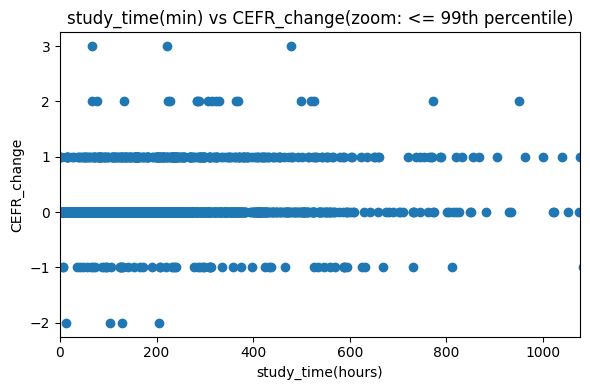

In [117]:
##散布図を描画する

import matplotlib.pyplot as plt
x = df_time_score['学習時間（時間）']
y = df_time_score['score_change']
corr_time_cefr=x.corr(y)

x_max = df_time_score['学習時間（時間）'].quantile(0.99)

plt.figure(figsize=(6, 4))
plt.scatter(x, y)
plt.xlim(0, x_max)
plt.title("study_time(min) vs CEFR_change(zoom: <= 99th percentile)")

plt.xlabel("study_time(hours)")
plt.ylabel("CEFR_change")
##plt.title("study_time(hours) vs CEFR_change")

plt.tight_layout()
plt.show()

In [119]:
corr_time_cefr=x.corr(y)
corr_time_cefr

np.float64(0.12399978169216136)